In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
voc_root = os.path.join(project_root, "data", "VOC2012")

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

from data import VOCDataset
from ssd.anchor import AnchorGenerator, TargetEncoder
from ssd.box_utils import point_form

In [3]:
dataset = VOCDataset(root=voc_root)
generator = AnchorGenerator()
encoder = TargetEncoder()

gt_boxes has shape torch.Size([2, 4])
gt_labels has shape torch.Size([2])


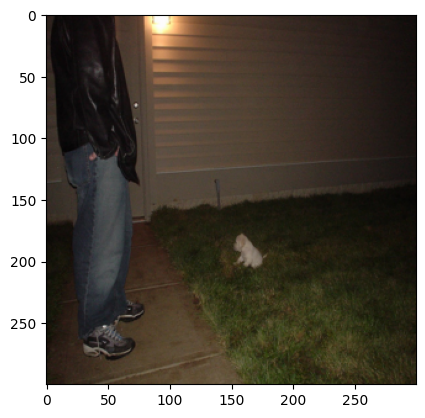

In [4]:
anchor_boxes = generator.anchor_boxes
priors = []
for layer in anchor_boxes:
    layer_priors = point_form(anchor_boxes[layer].view(-1, 4), clip=True)
    priors.append(layer_priors)
priors = torch.cat(priors, dim=0)    

img_tensor, bboxes = dataset[200]
img_tensor = img_tensor.permute(1, 2, 0).contiguous()

img = img_tensor.numpy() * 255
img = img.astype(np.uint8)
plt.imshow(img)

gt_boxes = bboxes[:, :4]
gt_labels = bboxes[:, 4]
print("gt_boxes has shape", gt_boxes.shape)
print("gt_labels has shape", gt_labels.shape)

matched_priors, matched_labels = encoder._match(gt_boxes, gt_labels, priors, iou_threshold=0.5)

Ground truth boxes are shown in yellow. Prior boxes are shown in red.

Found 33 non-background prior boxes


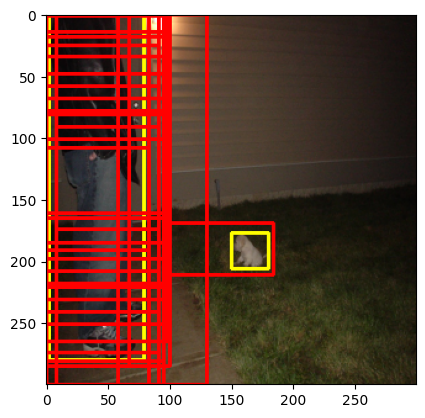

In [5]:
img = img_tensor.numpy() * 255
img = img.astype(np.uint8)
height, width, _ = img.shape

# Priors are matched to a ground truth box.
for matched_gt_box in matched_priors[matched_labels != 0]:
    xmin, ymin, xmax, ymax = matched_gt_box
    umin, vmin = int(xmin * width), int(ymin * height)
    umax, vmax = int(xmax * width), int(ymax * height)
    cv2.rectangle(img, (umin, vmin), (umax, vmax), color=(255, 255, 0), thickness=2)

# Compare it to the original prior box.
print("Found", priors[matched_labels != 0].size(0), "non-background prior boxes")
for prior_box in priors[matched_labels != 0]:
    xmin, ymin, xmax, ymax = prior_box
    umin, vmin = int(xmin * width), int(ymin * height)
    umax, vmax = int(xmax * width), int(ymax * height)
    cv2.rectangle(img, (umin, vmin), (umax, vmax), color=(255, 0, 0), thickness=2)

plt.imshow(img)